In [1]:
%matplotlib inline
import cv2
import os
# To turn off gpu
# os.environ['CUDA_VISIBLE_DEVICES']='-1'
os.environ['CUDA_VISIBLE_DEVICES']='-1'
import numpy as np 
import tensorflow as tf
print(tf.__version__)
from matplotlib import pyplot

2.3.1


In [2]:
import sys
sys.path.append('SauvolaDocBin/')
import pandas as pd
pd.set_option('display.float_format','{:.4f}'.format)
from dataUtils import collect_binarization_by_dataset, DataGenerator
from testUtils import prepare_inference, find_best_model
from layerUtils import *
from metrics import *

In [3]:
model_root = 'pretrained_models/'
for this in os.listdir(model_root) :
    if this.endswith('.h5') :
        model_filepath = os.path.join(model_root, this)
        model = prepare_inference(model_filepath)
model.summary()

/home/mansour/anaconda3/envs/v2/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:1045: UserWarning: modelUtils is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


Model: "Sauvola_v3_att_w7.15.23.31.39.47.55.63_k1_R1_a1_inorm"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img01_inp (InputLayer)          [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 8 80          img01_inp[0][0]                  
__________________________________________________________________________________________________
inorm0 (InstanceNormalization)  (None, None, None, 8 0           conv0[0][0]                      
__________________________________________________________________________________________________
relu0 (Activation)              (None, None, None, 8 0           inorm0[0][0]                     
______________________________________________

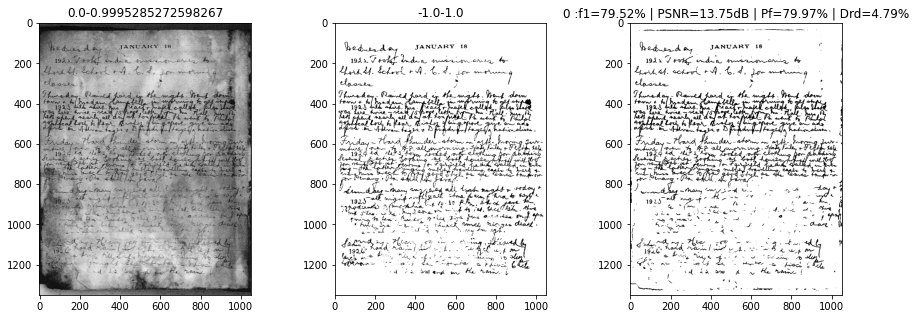

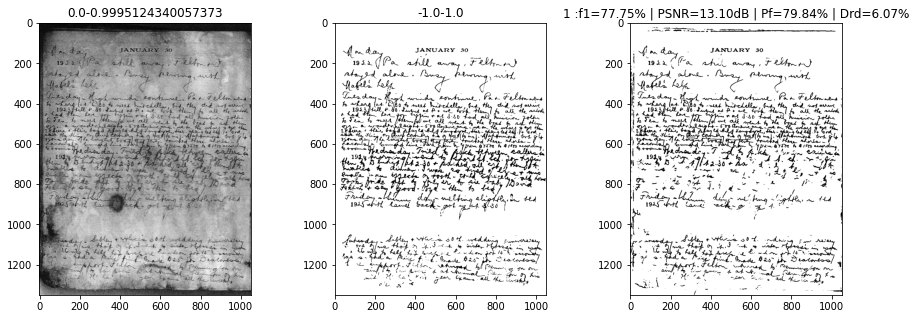

----------------------------------------------------------------------------------------------------
Total average : TRAIN [ 0.78633951 13.42160681  0.79905292  5.43109689]


In [5]:
dataset_lut = collect_binarization_by_dataset('Dataset')
test_datasets = ["TRAIN"]
for this in test_datasets :
    all_metrics = []
    test_datagen = DataGenerator(dataset_lut[this], output_shape=None, mode='testing')
    L = len(test_datagen)
    for i in range(2):# Replace 2 with L if the full dataset
        x, y = test_datagen[i]
        z = model.predict(x)
        pyplot.figure(figsize=(15,5))
        pyplot.subplot(131)
        pyplot.imshow(x[0,...,0], cmap='gray')
        pyplot.title('{}-{}'.format(x.min(), x.max()))
        pyplot.subplot(132)
        pyplot.imshow(y[0,...,0], cmap='gray', vmin=-1, vmax=1)
        pyplot.title('{}-{}'.format(y.min(), y.max()))
        pyplot.subplot(133)
        pyplot.imshow(z[0,...,0]>0, cmap='gray', vmin=0, vmax=1)
        pyplot.title(f'predicted {z.min():.2f} - {z.max():.2f}')
        f1 = Fmeasure(z[0,...,0]>0,y[0,...,0]>0)
        psnr = Psnr(z[0,...,0]>0,y[0,...,0]>0)
        Pf = Pfmeasure(z[0,...,0]>0,y[0,...,0]>0)
        drd = DRD(z[0,...,0]>0,y[0,...,0]>0)
        all_metrics.append([f1, psnr, Pf, drd])
        pyplot.title(f'{i} :f1={f1*100:.2f}% | PSNR={psnr:.2f}dB | Pf={Pf*100:.2f}% | Drd={drd:.2f}%')
        pyplot.show()
    print('-' * 100)
    print("Total average : " +this+" "+ str(np.mean(all_metrics,axis=0)))

In [6]:
from PIL import Image
import requests
def read_image_from_url(url) :
    im = Image.open(requests.get(url, stream=True).raw)
    rgb = np.array(im)
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    return gray, rgb

def decode_online_image(url, figsize=(10,5)) :
    gray, rgb = read_image_from_url(url)
    pyplot.figure(figsize=figsize)
    pyplot.subplot(121)
    pyplot.imshow(rgb,)
    pyplot.title('original RGB input')
    pyplot.subplot(122)
    x = gray.astype('float32')[None, ..., None]/255.
    pred = model.predict(x)
    pyplot.imshow(pred[0,...,0] > 0, cmap='gray')
    pyplot.title('predicted binary output')
    pyplot.show()

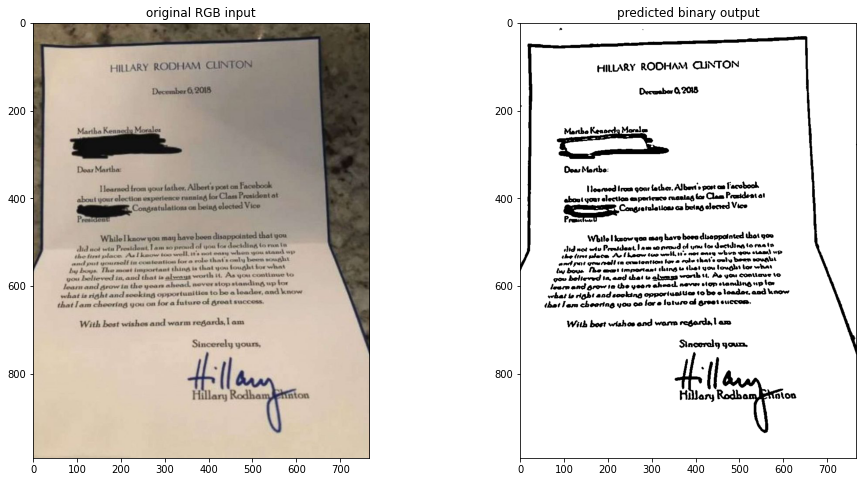

In [7]:
decode_online_image('https://s.abcnews.com/images/US/hillary-clinton-letter-wjla-mo-20181221_hpEmbed_10x13_992.jpg',figsize=(16,8))